In [82]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [64]:
# Load data
# Filmtrust
# Build UI matrix
users = []
items = []
scores = []
with open('./filmtrust/ratings.txt') as f:
#with open('./test_dataset/debug.txt') as f:
    for l in f.readlines():
        r = l.strip().split()
        users.append(int(r[0]))
        items.append(int(r[1]))
        scores.append(float(r[2]))

In [65]:
np.unique(scores)

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ])

In [66]:
UI_matrix = csr_matrix((scores, (users, items)))

## Graph Building

In [67]:
edges = []
user_nodes, item_nodes = [], [] 
max_user, max_item = 0, 0
for u, i, s in zip(users, items, scores):
    edges.append((f"U-{u}", f"I-{i}", {'s': s}))
    user_nodes.append(f"U-{u}")
    item_nodes.append(f"I-{i}")
    max_user = max(u, max_user)
    max_item = max(i, max_item)

user_nodes = np.unique(user_nodes)
item_nodes = np.unique(item_nodes)
print(f"user range [1-{max_user}]")
print(f"item range [1-{max_item}]")

user range [1-1508]
item range [1-2071]


In [68]:
G_source = nx.Graph(edges)

In [69]:
print(len(G_source.edges))

35494


## Algorithm Implementation

### Meta-path building

In [70]:
def meta_path_edges(G, rate_range):
    edge_dict = dict()
    for i in tqdm(item_nodes):
        adjacent_users = [u[0] for u in G.adj[i].items() if u[1]['s'] in rate_range]
        adjacent_users = sorted(adjacent_users, reverse=True)
        for j in range(len(adjacent_users)):
            u1 = adjacent_users[j]
            for k in range(j + 1, len(adjacent_users)):
                u2 = adjacent_users[k]
                if not edge_dict.get((u1, u2)): edge_dict[(u1, u2)] = 1
                else: edge_dict[(u1, u2)] += 1
    return edge_dict

def merge_metapaths(*args):
    P_edge_dict = args[0].copy()
    for edge_dict in args[1:]:
        for e in edge_dict:
            if P_edge_dict.get(e): P_edge_dict[e] += edge_dict[e]
            else: P_edge_dict[e] = edge_dict[e]
    return P_edge_dict

def normalize_edge_dict(edge_dict, mode='minmax'):
    if mode == 'minmax':
        min_weight, max_weight = np.min(list(edge_dict.values())), np.max(list(edge_dict.values()))
        for e in edge_dict:
            edge_dict[e] = 2 * ((edge_dict[e] - min_weight) / (max_weight - min_weight)) - 1
    else:
        raise NotImplementedError
    return edge_dict

Create Metapath Networks (it only return edges)

In [71]:
# 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. 

P1_edge_dict = meta_path_edges(G_source, [0.5, 1.0, 1.5])
P2_edge_dict = meta_path_edges(G_source, [2.0,2.5, 3.0])
P3_edge_dict = meta_path_edges(G_source, [3.5, 4.0])

100%|██████████| 2071/2071 [00:00<00:00, 2728.63it/s]


Add metapaths to build the U-U matrix (it actually creates de U-U edgelist)

In [ ]:
P_edge_dict = merge_metapaths(P1_edge_dict, P2_edge_dict, P3_edge_dict) # Join metapaths for U-U matrix

<Axes: ylabel='Count'>

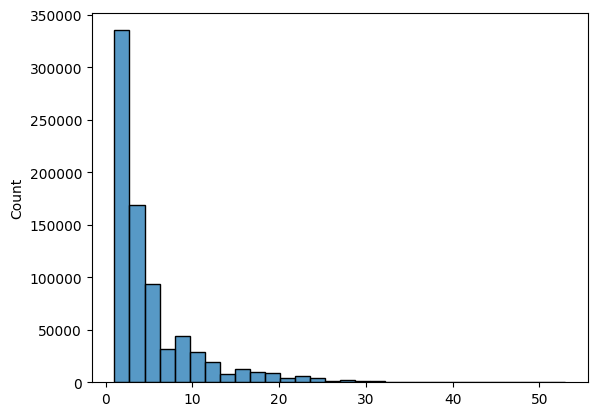

In [97]:
P_edge_weights = list(P_edge_dict.values())
sns.histplot(P_edge_weights, bins=30)

Most of the edge weights in the U-U matrix leans towards zero. The users that share items with similar ratings usually do it in a few movies.

In [72]:
P_edge_dict_norm = normalize_edge_dict(P_edge_dict.copy()) # Normalize(minmax)
S_main = nx.Graph([(k[0], k[1], {'s': v}) for k, v, in P_edge_dict_norm.items()]) # Buld S_main graph

In [73]:
print("User-User Network Description")
print("Nodes:", S_main.number_of_nodes(), "Edges:", S_main.number_of_edges())

User-User Network Description
Nodes: 1498 Edges: 783458


In [74]:
def draw_G(G):
    pos = nx.spring_layout(G, seed=7)
    
    nx.draw(G, pos, with_labels=True)
    edge_labels = nx.get_edge_attributes(G, 's')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

#plt.figure(figsize=(2,2))
#draw_G(S_main)
#nx.draw(S_main)

Scaling this poses a set of issues regarding the link prediction technique proposed by the authors of the paper. Using WAA (Weighted Adamic-Adar) for link prediction, and taking into account that most of our edges are negative means that we won't be able to calculate the weight due to the logarithm used.

<Axes: ylabel='Count'>

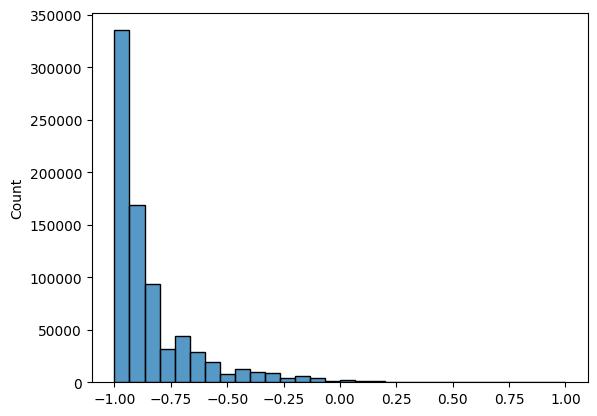

In [98]:
uu_edges = [(s, t, v['s'])for s, t, v in S_main.edges(data=True)]
uu_edge_weights = [i[2] for i in uu_edges]
sns.histplot(uu_edge_weights, bins=30)

### Link Prediction on U-U
Here we use the weighted adamic adar formula provided by the authors

$$score(u,v) = \sum_{z\in\Gamma(u)\cap\Gamma(v)}\frac{W(u,z) + W(v,z)}{2log(\sum_{z'\in\Gamma(z)}W(z,z'))}$$

* $u, v$: Users
* $\Gamma(u)$: Neighbors of $u$ in the network
* $W(u,v)$: Similarity between u and v as the weights of the link network
* $\Gamma(u)\cap\Gamma(v)$: Set of common neighbors of u and v

In [99]:
# Define lambda function to get weight from any graph
W = lambda G, u, v: G.get_edge_data(u, v, {'s': 0})['s']
print(W(S_main, 'U-1', 'U-2'))
print(W(S_main, 'U-1', 'U-4'))

# Use nx.common_neighbors(G, u, v) for the set of common neighbors between u and v
# Use nx.neighbors(G, u) or G.neighbors(u) for the set of neighbors of u

0
-1.0


In [102]:
# Weighted adamic-adar
def weighted_adamic_adar(G, u, v):
    sum_ = 0
    for z in nx.common_neighbors(G, u, v):
        sub_sum = (W(G, u, z) + W(G, v, z)) / (2*np.log(np.sum([W(G, z, zz) for zz in nx.neighbors(G, z)])))
        if np.isnan(sub_sum): sum_ += 0
        else: sum_ += sub_sum
    return sum_

# Testing
weighted_adamic_adar(S_main, 'U-1', 'U-3')

/tmp/ipykernel_23852/1453345246.py:5: RuntimeWarning: invalid value encountered in log
  sub_sum = (W(G, u, z) + W(G, v, z)) / (2*np.log(np.sum([W(G, z, zz) for zz in nx.neighbors(G, z)])))


0

Note that the authors didn't provided an explanation on what happens when the logarithm is negative or zero. In that case we asume that the same thing happens as in the adamic addar index when the nodes have no common neighbors

In [37]:
S_e = nx.Graph()
S_users = list(S_main.nodes)
for i in tqdm(range(len(S_users)), total=len(S_users)):
    for j in tqdm(range(i + 1, len(S_users))):
        u, v = S_users[i], S_users[j]
        if (W(S_main, u, v) is None or W(S_main, u, v) == 0.0) and u != v:
            waa = weighted_adamic_adar(S_main, u, v)
            if waa == 0: continue
            S_e.add_edge(u, v, s=waa)

  0%|          | 0/1452 [00:00<?, ?it/s]/tmp/ipykernel_23852/551290363.py:5: RuntimeWarning: invalid value encountered in log
  sum_ += (W(G, u, z) + W(G, v, z)) / (2*np.log(np.sum([W(G, z, zz) for zz in nx.neighbors(G, z)])))
  0%|          | 3/1452 [03:55<31:38:40, 78.62s/it]


KeyboardInterrupt: 

In [ ]:
# Update S_e with original edges
S_e.add_weighted_edges_from([(*x[0], x[1]) for x in nx.get_edge_attributes(S_main, 's').items()], 's')

We stopped the execution because this method is quite slow and has the limitations mentioned before. Our aim in this case is trying to use this U-U matrix we already generated, but change the way we generate new links between users using methods based on node2vec. https://keras.io/examples/graph/node2vec_movielens/ . In the example they embed an Item-Item matrix build through the mutual information extracted from user ratings, and use node2vec to generate embeddings of the movies to extract similar movies to an specific movie.

In our case, we want to use the U-U matrix we have already built to generate user embeddings and use cosine distance to determine if two users should be linked and the link probability

 ### Node2Vec Approach

In [104]:
!pip install stellargraph

ERROR: Ignored the following versions that require a different python version: 0.10.0 Requires-Python >=3.6.0, <3.8.0; 0.11.0 Requires-Python >=3.6.0, <3.8.0; 0.11.1 Requires-Python >=3.6.0, <3.8.0; 0.4.0 Requires-Python >=3.6,<3.7; 0.4.0b0 Requires-Python >=3.6,<3.7; 0.4.1 Requires-Python >=3.5.0, <3.7.0; 0.5.0 Requires-Python >=3.5.0, <3.7.0; 0.6.0 Requires-Python >=3.5.0, <3.7.0; 0.6.1 Requires-Python >=3.5.0, <3.7.0; 0.7.0 Requires-Python >=3.5.0, <3.8.0; 0.7.1 Requires-Python >=3.5.0, <3.8.0; 0.7.2 Requires-Python >=3.5.0, <3.8.0; 0.7.3 Requires-Python >=3.5.0, <3.8.0; 0.8.0 Requires-Python >=3.5.0, <3.8.0; 0.8.1 Requires-Python >=3.5.0, <3.8.0; 0.8.2 Requires-Python >=3.5.0, <3.8.0; 0.8.3 Requires-Python >=3.5.0, <3.8.0; 0.8.4 Requires-Python >=3.5.0, <3.8.0; 0.9.0 Requires-Python >=3.6.0, <3.8.0; 1.0.0 Requires-Python >=3.6.0, <3.8.0; 1.0.0rc1 Requires-Python >=3.6.0, <3.8.0; 1.1.0 Requires-Python >=3.6.0, <3.9.0; 1.2.0 Requires-Python >=3.6.0, <3.9.0; 1.2.1 Requires-Python >=3.

### Information Enhancing

In [276]:
u = "U-999"
i = "I-10"
#positive_neighbors = 

In [277]:
# sorted([u[0] for u in G.adj[i].items() if u[1]['s'] in rate_range], reverse=True)
[v[0] for v in S_e.adj[u].items() if v[1].get('s', -1) > 0]

[]

In [266]:
for v in S_e.adj[u].items():
    print(v[1]['s'])
    break

-25.597641665166538


In [289]:
[(e[0], e[1], e[2]) for e in S_e.edges(data='s')]

[('U-999', 'U-957', -14.608894399254318),
 ('U-999', 'U-847', -26.26600851934535),
 ('U-999', 'U-839', -15.84320764259906),
 ('U-999', 'U-790', -33.79467822853215),
 ('U-999', 'U-752', -14.589114749735897),
 ('U-999', 'U-69', -7.006972362763672),
 ('U-999', 'U-608', -23.626686127740953),
 ('U-999', 'U-590', -25.976172133500782),
 ('U-999', 'U-562', -18.47293792349786),
 ('U-999', 'U-56', -14.00986829606851),
 ('U-999', 'U-521', -7.006972362763672),
 ('U-999', 'U-393', -11.887884693679021),
 ('U-999', 'U-364', -7.006972362763672),
 ('U-999', 'U-362', -16.434574021294576),
 ('U-999', 'U-357', -7.006972362763672),
 ('U-999', 'U-306', -7.006972362763672),
 ('U-999', 'U-259', -11.790204122622596),
 ('U-999', 'U-232', -20.56693737628288),
 ('U-999', 'U-223', -24.567197538540384),
 ('U-999', 'U-198', -18.006808892763157),
 ('U-999', 'U-175', -13.816332427346524),
 ('U-999', 'U-1496', -15.170247398775706),
 ('U-999', 'U-1478', -26.699656238715363),
 ('U-999', 'U-1461', -22.689042842875164),
 (